In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/glass')
mask_dir = os.path.join(dataset_dir,'mask/glass')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/glass C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/glass
13135
13135


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-02-16 21:49:27,075: INFO: 3804955329: date_time: 20250216-214927]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "pspnet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-16 21:49:27,196: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-16 21:49:27,197: INFO: 342151172: model_config: {'model_name': 'pspnet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-16 21:49:27,198: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-16 21:49:27,198: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

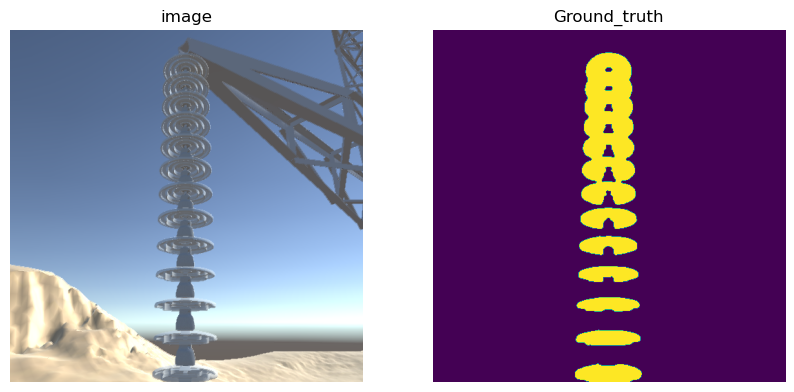

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-16 21:49:27,524: INFO: 3993860970: data injection started]
[2025-02-16 21:49:27,525: INFO: 3993860970: train data spliting ]
[2025-02-16 21:49:27,527: INFO: 3993860970: val test spliting ]
[2025-02-16 21:49:27,528: INFO: 3993860970: csv saving started]
[2025-02-16 21:49:27,543: INFO: 3993860970: train csv done ]
[2025-02-16 21:49:27,546: INFO: 3993860970: val csv done ]
[2025-02-16 21:49:27,549: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 1752/1752 [03:38<00:00,  8.01it/s, epoch=0, train_loss=0.0477, train_Miou_score=0.103, train_dice_score=0.149, train_acc=0.952, train_binary_jaccard_index=0.203, train_dice_coefficient=0.287]          

[2025-02-16 21:54:16,986: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.047691117138623104]
[2025-02-16 21:54:16,987: INFO: 2273413975: train_loss 0.05881110402915373]
[2025-02-16 21:54:16,987: INFO: 2273413975: train_Miou_score 0.10256668545483674]
[2025-02-16 21:54:16,988: INFO: 2273413975: train_dice_score 0.1485400530400179]
[2025-02-16 21:54:16,988: INFO: 2273413975: train_acc 0.9522872833815748]
[2025-02-16 21:54:16,988: INFO: 2273413975: train_binary_jaccard_index: 0.20332897163985994]
[2025-02-16 21:54:16,989: INFO: 2273413975: train_dice_coefficient: 0.2872369559827564]



100%|██████████| 657/657 [00:22<00:00, 29.28it/s, epoch=0, eval_loss=0.0341, eval_Miou_score=0.292, eval_dice_score=0.409, eval_acc=0.974, eval_binary_jaccard_index=0.518, eval_dice_coefficient=0.669]

[2025-02-16 21:54:39,425: INFO: 2273413975: Epoch: 0 | Loss: 0.034129487234344946]
[2025-02-16 21:54:39,426: INFO: 2273413975: eval_loss 0.03375828673604133]
[2025-02-16 21:54:39,426: INFO: 2273413975: eval_Miou_score 0.2920911321288919]
[2025-02-16 21:54:39,426: INFO: 2273413975: eval_dice_score 0.40920206650388474]
[2025-02-16 21:54:39,427: INFO: 2273413975: eval_acc 0.9741219501698579]
[2025-02-16 21:54:39,427: INFO: 2273413975: eval_binary_jaccard_index: 0.5179066317584053]
[2025-02-16 21:54:39,427: INFO: 2273413975: eval_dice_coefficient: 0.669393868837748]



100%|██████████| 1752/1752 [03:33<00:00,  8.22it/s, epoch=1, train_loss=0.0134, train_Miou_score=0.289, train_dice_score=0.333, train_acc=0.97, train_binary_jaccard_index=0.503, train_dice_coefficient=0.586] 

[2025-02-16 21:58:12,594: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.013439699429083088]
[2025-02-16 21:58:12,595: INFO: 2273413975: train_loss 0.04023458339718031]
[2025-02-16 21:58:12,595: INFO: 2273413975: train_Miou_score 0.28899410025718114]
[2025-02-16 21:58:12,595: INFO: 2273413975: train_dice_score 0.3326880784882313]
[2025-02-16 21:58:12,596: INFO: 2273413975: train_acc 0.9702344487408456]
[2025-02-16 21:58:12,596: INFO: 2273413975: train_binary_jaccard_index: 0.5030979601829152]
[2025-02-16 21:58:12,596: INFO: 2273413975: train_dice_coefficient: 0.5857090822226783]



100%|██████████| 657/657 [00:21<00:00, 31.02it/s, epoch=1, eval_loss=0.00741, eval_Miou_score=0.412, eval_dice_score=0.507, eval_acc=0.983, eval_binary_jaccard_index=0.691, eval_dice_coefficient=0.797]

[2025-02-16 21:58:33,777: INFO: 2273413975: Epoch: 1 | Loss: 0.00740667991623668]
[2025-02-16 21:58:33,777: INFO: 2273413975: eval_loss 0.020689141425494956]
[2025-02-16 21:58:33,777: INFO: 2273413975: eval_Miou_score 0.411923236697005]
[2025-02-16 21:58:33,778: INFO: 2273413975: eval_dice_score 0.506557534002278]
[2025-02-16 21:58:33,778: INFO: 2273413975: eval_acc 0.9834974309262257]
[2025-02-16 21:58:33,779: INFO: 2273413975: eval_binary_jaccard_index: 0.6907856828069578]
[2025-02-16 21:58:33,779: INFO: 2273413975: eval_dice_coefficient: 0.7970743218513339]



100%|██████████| 1752/1752 [03:33<00:00,  8.21it/s, epoch=2, train_loss=0.00788, train_Miou_score=0.368, train_dice_score=0.412, train_acc=0.978, train_binary_jaccard_index=0.626, train_dice_coefficient=0.701]

[2025-02-16 22:02:07,056: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.007882579174488102]
[2025-02-16 22:02:07,057: INFO: 2273413975: train_loss 0.02959899466361528]
[2025-02-16 22:02:07,057: INFO: 2273413975: train_Miou_score 0.3679847173388498]
[2025-02-16 22:02:07,057: INFO: 2273413975: train_dice_score 0.411955608636081]
[2025-02-16 22:02:07,058: INFO: 2273413975: train_acc 0.9775997925311599]
[2025-02-16 22:02:07,058: INFO: 2273413975: train_binary_jaccard_index: 0.6261179450248109]
[2025-02-16 22:02:07,059: INFO: 2273413975: train_dice_coefficient: 0.7007996271505765]



100%|██████████| 657/657 [00:21<00:00, 30.91it/s, epoch=2, eval_loss=0.0144, eval_Miou_score=0.428, eval_dice_score=0.522, eval_acc=0.984, eval_binary_jaccard_index=0.716, eval_dice_coefficient=0.817]

[2025-02-16 22:02:28,318: INFO: 2273413975: Epoch: 2 | Loss: 0.014357584887262168]
[2025-02-16 22:02:28,319: INFO: 2273413975: eval_loss 0.018392139640027467]
[2025-02-16 22:02:28,319: INFO: 2273413975: eval_Miou_score 0.42841242064397267]
[2025-02-16 22:02:28,319: INFO: 2273413975: eval_dice_score 0.5224650510596721]
[2025-02-16 22:02:28,320: INFO: 2273413975: eval_acc 0.9842599591042777]
[2025-02-16 22:02:28,320: INFO: 2273413975: eval_binary_jaccard_index: 0.7156036906643666]
[2025-02-16 22:02:28,321: INFO: 2273413975: eval_dice_coefficient: 0.8174761580264986]



100%|██████████| 1752/1752 [03:33<00:00,  8.20it/s, epoch=3, train_loss=0.0068, train_Miou_score=0.41, train_dice_score=0.457, train_acc=0.982, train_binary_jaccard_index=0.691, train_dice_coefficient=0.76]   

[2025-02-16 22:06:02,001: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.0068047726059068826]
[2025-02-16 22:06:02,001: INFO: 2273413975: train_loss 0.023893263848197992]
[2025-02-16 22:06:02,002: INFO: 2273413975: train_Miou_score 0.40991019093437747]
[2025-02-16 22:06:02,002: INFO: 2273413975: train_dice_score 0.4574560695284503]
[2025-02-16 22:06:02,003: INFO: 2273413975: train_acc 0.9815375155165418]
[2025-02-16 22:06:02,003: INFO: 2273413975: train_binary_jaccard_index: 0.691307646865469]
[2025-02-16 22:06:02,004: INFO: 2273413975: train_dice_coefficient: 0.7604921032298311]



100%|██████████| 657/657 [00:21<00:00, 30.87it/s, epoch=3, eval_loss=0.00684, eval_Miou_score=0.455, eval_dice_score=0.545, eval_acc=0.987, eval_binary_jaccard_index=0.755, eval_dice_coefficient=0.845]

[2025-02-16 22:06:23,290: INFO: 2273413975: Epoch: 3 | Loss: 0.0068398419217613375]
[2025-02-16 22:06:23,290: INFO: 2273413975: eval_loss 0.015537774835330708]
[2025-02-16 22:06:23,291: INFO: 2273413975: eval_Miou_score 0.45520311362383664]
[2025-02-16 22:06:23,292: INFO: 2273413975: eval_dice_score 0.5448710175126201]
[2025-02-16 22:06:23,292: INFO: 2273413975: eval_acc 0.9865258396851236]
[2025-02-16 22:06:23,292: INFO: 2273413975: eval_binary_jaccard_index: 0.7545110391852654]
[2025-02-16 22:06:23,293: INFO: 2273413975: eval_dice_coefficient: 0.8453912530519976]



100%|██████████| 1752/1752 [03:32<00:00,  8.24it/s, epoch=4, train_loss=0.00612, train_Miou_score=0.436, train_dice_score=0.488, train_acc=0.984, train_binary_jaccard_index=0.732, train_dice_coefficient=0.797]

[2025-02-16 22:09:55,823: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.0061197741526991265]
[2025-02-16 22:09:55,823: INFO: 2273413975: train_loss 0.020417398436459223]
[2025-02-16 22:09:55,824: INFO: 2273413975: train_Miou_score 0.4361622830613856]
[2025-02-16 22:09:55,824: INFO: 2273413975: train_dice_score 0.4878900415361249]
[2025-02-16 22:09:55,824: INFO: 2273413975: train_acc 0.98403025229874]
[2025-02-16 22:09:55,825: INFO: 2273413975: train_binary_jaccard_index: 0.7324703546018577]
[2025-02-16 22:09:55,825: INFO: 2273413975: train_dice_coefficient: 0.7974697880302472]



100%|██████████| 657/657 [00:21<00:00, 30.75it/s, epoch=4, eval_loss=0.00691, eval_Miou_score=0.471, eval_dice_score=0.56, eval_acc=0.988, eval_binary_jaccard_index=0.778, eval_dice_coefficient=0.862] 

[2025-02-16 22:10:17,191: INFO: 2273413975: Epoch: 4 | Loss: 0.006913598451077303]
[2025-02-16 22:10:17,191: INFO: 2273413975: eval_loss 0.013843642220155796]
[2025-02-16 22:10:17,192: INFO: 2273413975: eval_Miou_score 0.47050821285133493]
[2025-02-16 22:10:17,192: INFO: 2273413975: eval_dice_score 0.560039737807017]
[2025-02-16 22:10:17,193: INFO: 2273413975: eval_acc 0.9878602305140851]
[2025-02-16 22:10:17,193: INFO: 2273413975: eval_binary_jaccard_index: 0.7780721560982445]
[2025-02-16 22:10:17,193: INFO: 2273413975: eval_dice_coefficient: 0.8622555808718169]



100%|██████████| 1752/1752 [03:33<00:00,  8.19it/s, epoch=5, train_loss=0.006, train_Miou_score=0.454, train_dice_score=0.509, train_acc=0.986, train_binary_jaccard_index=0.76, train_dice_coefficient=0.822]   

[2025-02-16 22:13:51,136: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.005995269133347899]
[2025-02-16 22:13:51,136: INFO: 2273413975: train_loss 0.018089059822590618]
[2025-02-16 22:13:51,137: INFO: 2273413975: train_Miou_score 0.4538674156019195]
[2025-02-16 22:13:51,137: INFO: 2273413975: train_dice_score 0.5089871358605004]
[2025-02-16 22:13:51,138: INFO: 2273413975: train_acc 0.985709162963387]
[2025-02-16 22:13:51,138: INFO: 2273413975: train_binary_jaccard_index: 0.760198245299071]
[2025-02-16 22:13:51,139: INFO: 2273413975: train_dice_coefficient: 0.8222893376738105]



100%|██████████| 657/657 [00:21<00:00, 30.72it/s, epoch=5, eval_loss=0.00544, eval_Miou_score=0.484, eval_dice_score=0.573, eval_acc=0.989, eval_binary_jaccard_index=0.797, eval_dice_coefficient=0.876]

[2025-02-16 22:14:12,528: INFO: 2273413975: Epoch: 5 | Loss: 0.005444911426242265]
[2025-02-16 22:14:12,528: INFO: 2273413975: eval_loss 0.012436577010879872]
[2025-02-16 22:14:12,529: INFO: 2273413975: eval_Miou_score 0.4836252059245067]
[2025-02-16 22:14:12,529: INFO: 2273413975: eval_dice_score 0.5727133007747518]
[2025-02-16 22:14:12,529: INFO: 2273413975: eval_acc 0.9889926083011714]
[2025-02-16 22:14:12,530: INFO: 2273413975: eval_binary_jaccard_index: 0.7972304888281315]
[2025-02-16 22:14:12,530: INFO: 2273413975: eval_dice_coefficient: 0.8755597438360262]



100%|██████████| 1752/1752 [03:32<00:00,  8.23it/s, epoch=6, train_loss=0.00573, train_Miou_score=0.467, train_dice_score=0.525, train_acc=0.987, train_binary_jaccard_index=0.781, train_dice_coefficient=0.84] 

[2025-02-16 22:17:45,344: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.005725980417369163]
[2025-02-16 22:17:45,345: INFO: 2273413975: train_loss 0.016295136428356536]
[2025-02-16 22:17:45,345: INFO: 2273413975: train_Miou_score 0.4669458598841947]
[2025-02-16 22:17:45,346: INFO: 2273413975: train_dice_score 0.5254086391126258]
[2025-02-16 22:17:45,346: INFO: 2273413975: train_acc 0.9869442395635061]
[2025-02-16 22:17:45,347: INFO: 2273413975: train_binary_jaccard_index: 0.7805105317498566]
[2025-02-16 22:17:45,347: INFO: 2273413975: train_dice_coefficient: 0.8402831968867446]



100%|██████████| 657/657 [00:21<00:00, 30.06it/s, epoch=6, eval_loss=0.00542, eval_Miou_score=0.493, eval_dice_score=0.583, eval_acc=0.99, eval_binary_jaccard_index=0.811, eval_dice_coefficient=0.885] 

[2025-02-16 22:18:07,207: INFO: 2273413975: Epoch: 6 | Loss: 0.005419323977814417]
[2025-02-16 22:18:07,207: INFO: 2273413975: eval_loss 0.011445597084467862]
[2025-02-16 22:18:07,207: INFO: 2273413975: eval_Miou_score 0.4931860347449533]
[2025-02-16 22:18:07,209: INFO: 2273413975: eval_dice_score 0.5834694487630193]
[2025-02-16 22:18:07,209: INFO: 2273413975: eval_acc 0.9898038948326169]
[2025-02-16 22:18:07,210: INFO: 2273413975: eval_binary_jaccard_index: 0.8109235429415809]
[2025-02-16 22:18:07,210: INFO: 2273413975: eval_dice_coefficient: 0.8850599539480857]



100%|██████████| 1752/1752 [03:32<00:00,  8.25it/s, epoch=7, train_loss=0.00547, train_Miou_score=0.477, train_dice_score=0.539, train_acc=0.988, train_binary_jaccard_index=0.796, train_dice_coefficient=0.854]

[2025-02-16 22:21:39,518: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.005467083356151842]
[2025-02-16 22:21:39,518: INFO: 2273413975: train_loss 0.01496141936281754]
[2025-02-16 22:21:39,519: INFO: 2273413975: train_Miou_score 0.4771847412905001]
[2025-02-16 22:21:39,519: INFO: 2273413975: train_dice_score 0.5386979652315272]
[2025-02-16 22:21:39,520: INFO: 2273413975: train_acc 0.9879019916404175]
[2025-02-16 22:21:39,520: INFO: 2273413975: train_binary_jaccard_index: 0.7962901560555955]
[2025-02-16 22:21:39,521: INFO: 2273413975: train_dice_coefficient: 0.8540971063349027]



100%|██████████| 657/657 [00:21<00:00, 30.51it/s, epoch=7, eval_loss=0.00591, eval_Miou_score=0.5, eval_dice_score=0.589, eval_acc=0.99, eval_binary_jaccard_index=0.821, eval_dice_coefficient=0.892]  

[2025-02-16 22:22:01,057: INFO: 2273413975: Epoch: 7 | Loss: 0.005912986610940965]
[2025-02-16 22:22:01,057: INFO: 2273413975: eval_loss 0.010750647068449363]
[2025-02-16 22:22:01,058: INFO: 2273413975: eval_Miou_score 0.4997948628965102]
[2025-02-16 22:22:01,058: INFO: 2273413975: eval_dice_score 0.5887907022961856]
[2025-02-16 22:22:01,059: INFO: 2273413975: eval_acc 0.9903490412725161]
[2025-02-16 22:22:01,059: INFO: 2273413975: eval_binary_jaccard_index: 0.8205720757884136]
[2025-02-16 22:22:01,059: INFO: 2273413975: eval_dice_coefficient: 0.8918384163696234]



100%|██████████| 1752/1752 [03:33<00:00,  8.20it/s, epoch=8, train_loss=0.00507, train_Miou_score=0.486, train_dice_score=0.55, train_acc=0.989, train_binary_jaccard_index=0.809, train_dice_coefficient=0.865] 

[2025-02-16 22:25:34,651: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.005065567145064541]
[2025-02-16 22:25:34,651: INFO: 2273413975: train_loss 0.013866100658577074]
[2025-02-16 22:25:34,652: INFO: 2273413975: train_Miou_score 0.48550292550766116]
[2025-02-16 22:25:34,652: INFO: 2273413975: train_dice_score 0.5498834497638486]
[2025-02-16 22:25:34,653: INFO: 2273413975: train_acc 0.9886904894797209]
[2025-02-16 22:25:34,653: INFO: 2273413975: train_binary_jaccard_index: 0.8091752992985727]
[2025-02-16 22:25:34,653: INFO: 2273413975: train_dice_coefficient: 0.8651785017154408]



100%|██████████| 657/657 [00:21<00:00, 30.57it/s, epoch=8, eval_loss=0.00496, eval_Miou_score=0.506, eval_dice_score=0.596, eval_acc=0.991, eval_binary_jaccard_index=0.829, eval_dice_coefficient=0.898]

[2025-02-16 22:25:56,145: INFO: 2273413975: Epoch: 8 | Loss: 0.004960930420020581]
[2025-02-16 22:25:56,146: INFO: 2273413975: eval_loss 0.010105762586634877]
[2025-02-16 22:25:56,147: INFO: 2273413975: eval_Miou_score 0.5058056769091507]
[2025-02-16 22:25:56,147: INFO: 2273413975: eval_dice_score 0.5964487779733696]
[2025-02-16 22:25:56,147: INFO: 2273413975: eval_acc 0.9908776011500043]
[2025-02-16 22:25:56,148: INFO: 2273413975: eval_binary_jaccard_index: 0.8292885243769187]
[2025-02-16 22:25:56,148: INFO: 2273413975: eval_dice_coefficient: 0.8977812196064946]



100%|██████████| 1752/1752 [03:33<00:00,  8.20it/s, epoch=9, train_loss=0.00523, train_Miou_score=0.492, train_dice_score=0.559, train_acc=0.989, train_binary_jaccard_index=0.819, train_dice_coefficient=0.874]

[2025-02-16 22:29:29,771: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.005227648130018418]
[2025-02-16 22:29:29,771: INFO: 2273413975: train_loss 0.013009637582870359]
[2025-02-16 22:29:29,772: INFO: 2273413975: train_Miou_score 0.4919773972762921]
[2025-02-16 22:29:29,772: INFO: 2273413975: train_dice_score 0.5588493619615653]
[2025-02-16 22:29:29,772: INFO: 2273413975: train_acc 0.9893044475950811]
[2025-02-16 22:29:29,773: INFO: 2273413975: train_binary_jaccard_index: 0.8192843922932098]
[2025-02-16 22:29:29,773: INFO: 2273413975: train_dice_coefficient: 0.8739341606562694]



100%|██████████| 657/657 [00:21<00:00, 30.14it/s, epoch=9, eval_loss=0.00549, eval_Miou_score=0.51, eval_dice_score=0.603, eval_acc=0.991, eval_binary_jaccard_index=0.835, eval_dice_coefficient=0.902] 

[2025-02-16 22:29:51,572: INFO: 2273413975: Epoch: 9 | Loss: 0.005485704772548589]
[2025-02-16 22:29:51,573: INFO: 2273413975: eval_loss 0.009647720639300762]
[2025-02-16 22:29:51,573: INFO: 2273413975: eval_Miou_score 0.510100364216704]
[2025-02-16 22:29:51,574: INFO: 2273413975: eval_dice_score 0.6028654002129488]
[2025-02-16 22:29:51,574: INFO: 2273413975: eval_acc 0.9912469085855934]
[2025-02-16 22:29:51,575: INFO: 2273413975: eval_binary_jaccard_index: 0.83540224037282]
[2025-02-16 22:29:51,575: INFO: 2273413975: eval_dice_coefficient: 0.9020508070548523]



100%|██████████| 1752/1752 [03:33<00:00,  8.20it/s, epoch=10, train_loss=0.00514, train_Miou_score=0.497, train_dice_score=0.566, train_acc=0.99, train_binary_jaccard_index=0.828, train_dice_coefficient=0.881]

[2025-02-16 22:33:25,264: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.005143438095915808]
[2025-02-16 22:33:25,265: INFO: 2273413975: train_loss 0.012297638785332356]
[2025-02-16 22:33:25,266: INFO: 2273413975: train_Miou_score 0.4973504998971694]
[2025-02-16 22:33:25,266: INFO: 2273413975: train_dice_score 0.5664878405039575]
[2025-02-16 22:33:25,267: INFO: 2273413975: train_acc 0.989814053439207]
[2025-02-16 22:33:25,267: INFO: 2273413975: train_binary_jaccard_index: 0.8276964758010784]
[2025-02-16 22:33:25,267: INFO: 2273413975: train_dice_coefficient: 0.8811740023703528]



100%|██████████| 657/657 [00:21<00:00, 30.11it/s, epoch=10, eval_loss=0.00487, eval_Miou_score=0.514, eval_dice_score=0.608, eval_acc=0.992, eval_binary_jaccard_index=0.841, eval_dice_coefficient=0.906]

[2025-02-16 22:33:47,087: INFO: 2273413975: Epoch: 10 | Loss: 0.004865372108360766]
[2025-02-16 22:33:47,087: INFO: 2273413975: eval_loss 0.009214691095861413]
[2025-02-16 22:33:47,088: INFO: 2273413975: eval_Miou_score 0.5141773416919878]
[2025-02-16 22:33:47,088: INFO: 2273413975: eval_dice_score 0.608396457364133]
[2025-02-16 22:33:47,089: INFO: 2273413975: eval_acc 0.9916050949086123]
[2025-02-16 22:33:47,089: INFO: 2273413975: eval_binary_jaccard_index: 0.841232717085655]
[2025-02-16 22:33:47,089: INFO: 2273413975: eval_dice_coefficient: 0.9060170851685269]



100%|██████████| 1752/1752 [03:35<00:00,  8.11it/s, epoch=11, train_loss=0.00501, train_Miou_score=0.502, train_dice_score=0.573, train_acc=0.99, train_binary_jaccard_index=0.835, train_dice_coefficient=0.887]

[2025-02-16 22:37:23,017: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.00500792193494431]
[2025-02-16 22:37:23,018: INFO: 2273413975: train_loss 0.01168424208501962]
[2025-02-16 22:37:23,018: INFO: 2273413975: train_Miou_score 0.5020131538221266]
[2025-02-16 22:37:23,019: INFO: 2273413975: train_dice_score 0.5730189236640508]
[2025-02-16 22:37:23,019: INFO: 2273413975: train_acc 0.9902497594644524]
[2025-02-16 22:37:23,020: INFO: 2273413975: train_binary_jaccard_index: 0.8348393963278677]
[2025-02-16 22:37:23,020: INFO: 2273413975: train_dice_coefficient: 0.8872817892111244]



100%|██████████| 657/657 [00:21<00:00, 30.29it/s, epoch=11, eval_loss=0.0048, eval_Miou_score=0.518, eval_dice_score=0.613, eval_acc=0.992, eval_binary_jaccard_index=0.846, eval_dice_coefficient=0.909] 

[2025-02-16 22:37:44,711: INFO: 2273413975: Epoch: 11 | Loss: 0.004804285421763381]
[2025-02-16 22:37:44,712: INFO: 2273413975: eval_loss 0.008836988234234535]
[2025-02-16 22:37:44,712: INFO: 2273413975: eval_Miou_score 0.5175309046934714]
[2025-02-16 22:37:44,712: INFO: 2273413975: eval_dice_score 0.6132368102323836]
[2025-02-16 22:37:44,713: INFO: 2273413975: eval_acc 0.9919081626961764]
[2025-02-16 22:37:44,713: INFO: 2273413975: eval_binary_jaccard_index: 0.8461234005019711]
[2025-02-16 22:37:44,714: INFO: 2273413975: eval_dice_coefficient: 0.9093335253413031]



100%|██████████| 1752/1752 [03:34<00:00,  8.17it/s, epoch=12, train_loss=0.00512, train_Miou_score=0.506, train_dice_score=0.579, train_acc=0.991, train_binary_jaccard_index=0.841, train_dice_coefficient=0.892]

[2025-02-16 22:41:19,266: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.005120188338027153]
[2025-02-16 22:41:19,267: INFO: 2273413975: train_loss 0.01116844810583902]
[2025-02-16 22:41:19,267: INFO: 2273413975: train_Miou_score 0.5059222883649537]
[2025-02-16 22:41:19,268: INFO: 2273413975: train_dice_score 0.5787551383928273]
[2025-02-16 22:41:19,268: INFO: 2273413975: train_acc 0.9906094987966019]
[2025-02-16 22:41:19,269: INFO: 2273413975: train_binary_jaccard_index: 0.8407929447368839]
[2025-02-16 22:41:19,269: INFO: 2273413975: train_dice_coefficient: 0.8923921621930586]



100%|██████████| 657/657 [00:21<00:00, 30.19it/s, epoch=12, eval_loss=0.00476, eval_Miou_score=0.52, eval_dice_score=0.617, eval_acc=0.992, eval_binary_jaccard_index=0.85, eval_dice_coefficient=0.912]  

[2025-02-16 22:41:41,033: INFO: 2273413975: Epoch: 12 | Loss: 0.004761979460171913]
[2025-02-16 22:41:41,033: INFO: 2273413975: eval_loss 0.008531329578417759]
[2025-02-16 22:41:41,034: INFO: 2273413975: eval_Miou_score 0.5203774018264838]
[2025-02-16 22:41:41,034: INFO: 2273413975: eval_dice_score 0.6173340205524931]
[2025-02-16 22:41:41,035: INFO: 2273413975: eval_acc 0.9921681261526004]
[2025-02-16 22:41:41,035: INFO: 2273413975: eval_binary_jaccard_index: 0.8503663965086861]
[2025-02-16 22:41:41,035: INFO: 2273413975: eval_dice_coefficient: 0.9122139227381484]



100%|██████████| 1752/1752 [03:31<00:00,  8.27it/s, epoch=13, train_loss=0.00475, train_Miou_score=0.509, train_dice_score=0.584, train_acc=0.991, train_binary_jaccard_index=0.846, train_dice_coefficient=0.897]

[2025-02-16 22:45:12,814: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.0047497605420138735]
[2025-02-16 22:45:12,814: INFO: 2273413975: train_loss 0.010707182026338384]
[2025-02-16 22:45:12,814: INFO: 2273413975: train_Miou_score 0.509365315508645]
[2025-02-16 22:45:12,815: INFO: 2273413975: train_dice_score 0.5841439318455972]
[2025-02-16 22:45:12,816: INFO: 2273413975: train_acc 0.9909442383850653]
[2025-02-16 22:45:12,816: INFO: 2273413975: train_binary_jaccard_index: 0.8462624254238718]
[2025-02-16 22:45:12,817: INFO: 2273413975: train_dice_coefficient: 0.8969823786489627]



100%|██████████| 657/657 [00:21<00:00, 30.45it/s, epoch=13, eval_loss=0.00488, eval_Miou_score=0.523, eval_dice_score=0.621, eval_acc=0.992, eval_binary_jaccard_index=0.854, eval_dice_coefficient=0.915]

[2025-02-16 22:45:34,398: INFO: 2273413975: Epoch: 13 | Loss: 0.004882899049210221]
[2025-02-16 22:45:34,399: INFO: 2273413975: eval_loss 0.008263095216169117]
[2025-02-16 22:45:34,399: INFO: 2273413975: eval_Miou_score 0.5228349581080549]
[2025-02-16 22:45:34,399: INFO: 2273413975: eval_dice_score 0.6207002314023478]
[2025-02-16 22:45:34,400: INFO: 2273413975: eval_acc 0.9923821101112972]
[2025-02-16 22:45:34,400: INFO: 2273413975: eval_binary_jaccard_index: 0.853857625078205]
[2025-02-16 22:45:34,401: INFO: 2273413975: eval_dice_coefficient: 0.914584609556186]



100%|██████████| 1752/1752 [03:33<00:00,  8.22it/s, epoch=14, train_loss=0.0047, train_Miou_score=0.513, train_dice_score=0.589, train_acc=0.991, train_binary_jaccard_index=0.851, train_dice_coefficient=0.901] 

[2025-02-16 22:49:07,664: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0046966116382106795]
[2025-02-16 22:49:07,665: INFO: 2273413975: train_loss 0.01030794408671805]
[2025-02-16 22:49:07,665: INFO: 2273413975: train_Miou_score 0.5125230409797202]
[2025-02-16 22:49:07,666: INFO: 2273413975: train_dice_score 0.5891722896066673]
[2025-02-16 22:49:07,666: INFO: 2273413975: train_acc 0.9912377142918664]
[2025-02-16 22:49:07,666: INFO: 2273413975: train_binary_jaccard_index: 0.851045921296578]
[2025-02-16 22:49:07,667: INFO: 2273413975: train_dice_coefficient: 0.9009836776716417]



100%|██████████| 657/657 [00:21<00:00, 30.34it/s, epoch=14, eval_loss=0.00468, eval_Miou_score=0.525, eval_dice_score=0.623, eval_acc=0.993, eval_binary_jaccard_index=0.857, eval_dice_coefficient=0.917]

[2025-02-16 22:49:29,321: INFO: 2273413975: Epoch: 14 | Loss: 0.004677777058094785]
[2025-02-16 22:49:29,321: INFO: 2273413975: eval_loss 0.008018531010928955]
[2025-02-16 22:49:29,322: INFO: 2273413975: eval_Miou_score 0.5253231571228416]
[2025-02-16 22:49:29,322: INFO: 2273413975: eval_dice_score 0.6229301480889199]
[2025-02-16 22:49:29,323: INFO: 2273413975: eval_acc 0.9925815208740854]
[2025-02-16 22:49:29,323: INFO: 2273413975: eval_binary_jaccard_index: 0.857144412383974]
[2025-02-16 22:49:29,324: INFO: 2273413975: eval_dice_coefficient: 0.9167849934333762]



100%|██████████| 1752/1752 [03:33<00:00,  8.22it/s, epoch=15, train_loss=0.00477, train_Miou_score=0.515, train_dice_score=0.593, train_acc=0.991, train_binary_jaccard_index=0.855, train_dice_coefficient=0.904]

[2025-02-16 22:53:02,379: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.004766420414458671]
[2025-02-16 22:53:02,379: INFO: 2273413975: train_loss 0.009955156666828547]
[2025-02-16 22:53:02,380: INFO: 2273413975: train_Miou_score 0.5151651836880936]
[2025-02-16 22:53:02,380: INFO: 2273413975: train_dice_score 0.5933463970245809]
[2025-02-16 22:53:02,380: INFO: 2273413975: train_acc 0.9914899858062424]
[2025-02-16 22:53:02,381: INFO: 2273413975: train_binary_jaccard_index: 0.85516766769745]
[2025-02-16 22:53:02,381: INFO: 2273413975: train_dice_coefficient: 0.9044491095486686]



100%|██████████| 657/657 [00:22<00:00, 29.86it/s, epoch=15, eval_loss=0.00464, eval_Miou_score=0.527, eval_dice_score=0.626, eval_acc=0.993, eval_binary_jaccard_index=0.86, eval_dice_coefficient=0.919] 

[2025-02-16 22:53:24,385: INFO: 2273413975: Epoch: 15 | Loss: 0.004643023739848144]
[2025-02-16 22:53:24,386: INFO: 2273413975: eval_loss 0.007804556421339591]
[2025-02-16 22:53:24,386: INFO: 2273413975: eval_Miou_score 0.5271671434908346]
[2025-02-16 22:53:24,387: INFO: 2273413975: eval_dice_score 0.6261709598233268]
[2025-02-16 22:53:24,387: INFO: 2273413975: eval_acc 0.9927580897303658]
[2025-02-16 22:53:24,387: INFO: 2273413975: eval_binary_jaccard_index: 0.8602086149058283]
[2025-02-16 22:53:24,388: INFO: 2273413975: eval_dice_coefficient: 0.9188382921948712]



100%|██████████| 1752/1752 [03:33<00:00,  8.20it/s, epoch=16, train_loss=0.00477, train_Miou_score=0.517, train_dice_score=0.597, train_acc=0.992, train_binary_jaccard_index=0.859, train_dice_coefficient=0.908]

[2025-02-16 22:56:58,160: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.004768788950628342]
[2025-02-16 22:56:58,160: INFO: 2273413975: train_loss 0.009645937478078667]
[2025-02-16 22:56:58,161: INFO: 2273413975: train_Miou_score 0.5174927424182428]
[2025-02-16 22:56:58,161: INFO: 2273413975: train_dice_score 0.5969605050438526]
[2025-02-16 22:56:58,162: INFO: 2273413975: train_acc 0.9917123512072995]
[2025-02-16 22:56:58,162: INFO: 2273413975: train_binary_jaccard_index: 0.8588172653414454]
[2025-02-16 22:56:58,163: INFO: 2273413975: train_dice_coefficient: 0.9075138614011735]



100%|██████████| 657/657 [00:21<00:00, 29.99it/s, epoch=16, eval_loss=0.00461, eval_Miou_score=0.529, eval_dice_score=0.628, eval_acc=0.993, eval_binary_jaccard_index=0.863, eval_dice_coefficient=0.921]

[2025-02-16 22:57:20,073: INFO: 2273413975: Epoch: 16 | Loss: 0.004608164729955897]
[2025-02-16 22:57:20,074: INFO: 2273413975: eval_loss 0.007615553430790879]
[2025-02-16 22:57:20,074: INFO: 2273413975: eval_Miou_score 0.5289432784611316]
[2025-02-16 22:57:20,074: INFO: 2273413975: eval_dice_score 0.6284353462329632]
[2025-02-16 22:57:20,075: INFO: 2273413975: eval_acc 0.9929155168201175]
[2025-02-16 22:57:20,075: INFO: 2273413975: eval_binary_jaccard_index: 0.8627983285725378]
[2025-02-16 22:57:20,075: INFO: 2273413975: eval_dice_coefficient: 0.9205686367578312]



100%|██████████| 1752/1752 [03:34<00:00,  8.18it/s, epoch=17, train_loss=0.00461, train_Miou_score=0.52, train_dice_score=0.601, train_acc=0.992, train_binary_jaccard_index=0.862, train_dice_coefficient=0.91]  

[2025-02-16 23:00:54,247: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.0046062373883648]
[2025-02-16 23:00:54,247: INFO: 2273413975: train_loss 0.009365430761934522]
[2025-02-16 23:00:54,247: INFO: 2273413975: train_Miou_score 0.5196426281653754]
[2025-02-16 23:00:54,248: INFO: 2273413975: train_dice_score 0.6005650299706452]
[2025-02-16 23:00:54,248: INFO: 2273413975: train_acc 0.9919190088585624]
[2025-02-16 23:00:54,249: INFO: 2273413975: train_binary_jaccard_index: 0.8622020248397526]
[2025-02-16 23:00:54,249: INFO: 2273413975: train_dice_coefficient: 0.9103164503809891]



100%|██████████| 657/657 [00:22<00:00, 29.82it/s, epoch=17, eval_loss=0.00456, eval_Miou_score=0.531, eval_dice_score=0.631, eval_acc=0.993, eval_binary_jaccard_index=0.865, eval_dice_coefficient=0.922]

[2025-02-16 23:01:16,285: INFO: 2273413975: Epoch: 17 | Loss: 0.004559023920985299]
[2025-02-16 23:01:16,285: INFO: 2273413975: eval_loss 0.0074484152653924605]
[2025-02-16 23:01:16,286: INFO: 2273413975: eval_Miou_score 0.5306986825723051]
[2025-02-16 23:01:16,286: INFO: 2273413975: eval_dice_score 0.6309301735032851]
[2025-02-16 23:01:16,286: INFO: 2273413975: eval_acc 0.9930578501478944]
[2025-02-16 23:01:16,287: INFO: 2273413975: eval_binary_jaccard_index: 0.8651486709896641]
[2025-02-16 23:01:16,287: INFO: 2273413975: eval_dice_coefficient: 0.9221397590199149]



100%|██████████| 1752/1752 [03:33<00:00,  8.19it/s, epoch=18, train_loss=0.00462, train_Miou_score=0.522, train_dice_score=0.604, train_acc=0.992, train_binary_jaccard_index=0.865, train_dice_coefficient=0.913]

[2025-02-16 23:04:50,241: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.004621751538422554]
[2025-02-16 23:04:50,242: INFO: 2273413975: train_loss 0.009112099737080223]
[2025-02-16 23:04:50,242: INFO: 2273413975: train_Miou_score 0.52158504865799]
[2025-02-16 23:04:50,243: INFO: 2273413975: train_dice_score 0.6037790747912068]
[2025-02-16 23:04:50,243: INFO: 2273413975: train_acc 0.9921029826043797]
[2025-02-16 23:04:50,244: INFO: 2273413975: train_binary_jaccard_index: 0.8651989404390663]
[2025-02-16 23:04:50,244: INFO: 2273413975: train_dice_coefficient: 0.9128056681480039]



100%|██████████| 657/657 [00:22<00:00, 29.69it/s, epoch=18, eval_loss=0.00436, eval_Miou_score=0.532, eval_dice_score=0.634, eval_acc=0.993, eval_binary_jaccard_index=0.868, eval_dice_coefficient=0.924]

[2025-02-16 23:05:12,376: INFO: 2273413975: Epoch: 18 | Loss: 0.004364802322068352]
[2025-02-16 23:05:12,376: INFO: 2273413975: eval_loss 0.007283903851306423]
[2025-02-16 23:05:12,376: INFO: 2273413975: eval_Miou_score 0.5323252753366322]
[2025-02-16 23:05:12,377: INFO: 2273413975: eval_dice_score 0.6335784239606589]
[2025-02-16 23:05:12,377: INFO: 2273413975: eval_acc 0.9931953617808892]
[2025-02-16 23:05:12,377: INFO: 2273413975: eval_binary_jaccard_index: 0.8675565533331024]
[2025-02-16 23:05:12,378: INFO: 2273413975: eval_dice_coefficient: 0.9237252640536464]



100%|██████████| 1752/1752 [03:36<00:00,  8.11it/s, epoch=19, train_loss=0.00462, train_Miou_score=0.523, train_dice_score=0.607, train_acc=0.992, train_binary_jaccard_index=0.868, train_dice_coefficient=0.915]

[2025-02-16 23:08:48,427: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0046176266044242196]
[2025-02-16 23:08:48,428: INFO: 2273413975: train_loss 0.008884291723077286]
[2025-02-16 23:08:48,428: INFO: 2273413975: train_Miou_score 0.5233491758005605]
[2025-02-16 23:08:48,429: INFO: 2273413975: train_dice_score 0.6068370723739517]
[2025-02-16 23:08:48,429: INFO: 2273413975: train_acc 0.9922687302539167]
[2025-02-16 23:08:48,430: INFO: 2273413975: train_binary_jaccard_index: 0.867912288191464]
[2025-02-16 23:08:48,430: INFO: 2273413975: train_dice_coefficient: 0.9150547806065147]



100%|██████████| 657/657 [00:21<00:00, 29.97it/s, epoch=19, eval_loss=0.00475, eval_Miou_score=0.534, eval_dice_score=0.635, eval_acc=0.993, eval_binary_jaccard_index=0.869, eval_dice_coefficient=0.925]

[2025-02-16 23:09:10,354: INFO: 2273413975: Epoch: 19 | Loss: 0.004750614931957181]
[2025-02-16 23:09:10,354: INFO: 2273413975: eval_loss 0.0071565768111144295]
[2025-02-16 23:09:10,354: INFO: 2273413975: eval_Miou_score 0.533509229366842]
[2025-02-16 23:09:10,355: INFO: 2273413975: eval_dice_score 0.635335150360494]
[2025-02-16 23:09:10,355: INFO: 2273413975: eval_acc 0.9933000235071284]
[2025-02-16 23:09:10,356: INFO: 2273413975: eval_binary_jaccard_index: 0.8693361355873502]
[2025-02-16 23:09:10,356: INFO: 2273413975: eval_dice_coefficient: 0.9249315777349125]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 657/657 [00:23<00:00, 28.25it/s, loss=0.00477, Miou_score=0.558, dice_score=0.671, acc=0.995, binary_jaccard_index=0.905, dice_coefficient=0.949]

[2025-02-16 23:09:33,632: INFO: 580206084: Test Loss: 0.004768303086587102]
[2025-02-16 23:09:33,633: INFO: 580206084: Test Miou_score: 0.5581161754724642]
[2025-02-16 23:09:33,633: INFO: 580206084: Test dice_score: 0.671468022433953]
[2025-02-16 23:09:33,633: INFO: 580206084: Test acc: 0.9952671538749241]
[2025-02-16 23:09:33,634: INFO: 580206084: test_dice_coefficient: 0.9488305621896632]
[2025-02-16 23:09:33,634: INFO: 580206084: Test binary_jaccard_index: 0.9046550892985212]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

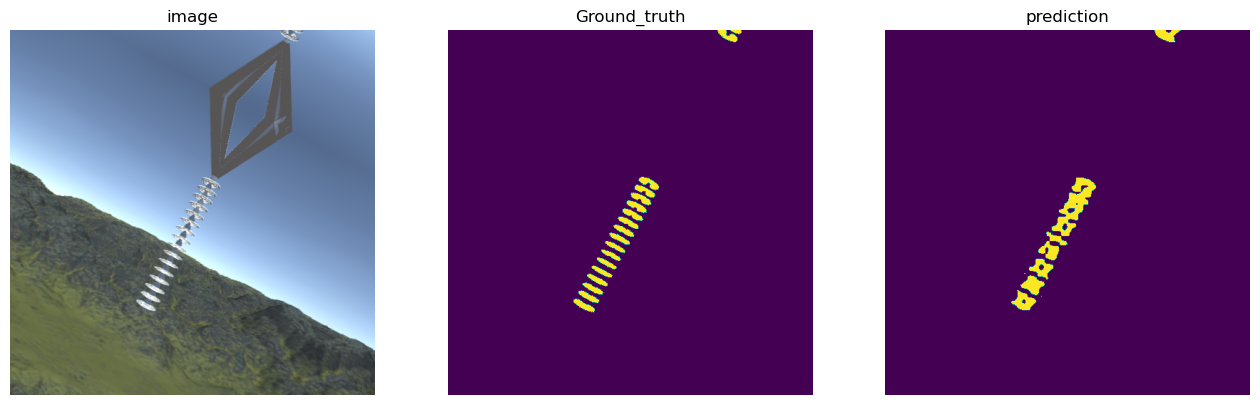

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_glass.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/pspnet_resnet50_glass.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_8064\1821799983.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()